# Method 3 - Best Fresh Ideas DGTW Timing

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Novus HFU

novus_hfu = hfu.get_novus_hfu()

# Get HFU Data

%store -r inst_data

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Get Returns for Fresh Ideas

%store -r r

# Get Adjusted Quantities

qty_pivot = pd.pivot_table(inst_data, index='datadate', columns=['institution_id', 'fsym_id'], values='quantity',
                           aggfunc='sum')
qty_pivot = qty_pivot.mul(r.splits.reindex(qty_pivot.index), level=1).fillna(0)
qty_pivot = qty_pivot - qty_pivot.shift(1)
flat_qty = pd.melt(qty_pivot.reset_index(), id_vars='datadate', value_name='qty_change')
flat_qty = flat_qty[flat_qty['qty_change'] > 0]

# Get Pos Size Change

pos_size_pivot = pd.pivot_table(inst_data, index='datadate', columns=['institution_id', 'fsym_id'], values='target',
                                aggfunc='sum')
pos_size_pivot = pos_size_pivot - pos_size_pivot.shift(1)
flat_pos_size = pd.melt(pos_size_pivot.reset_index(), id_vars='datadate', value_name='size_change')
flat_pos_size = flat_pos_size[flat_pos_size['size_change'] > 0]

# Calculate Intra-Portfolio Cap Weight

valid_data['weight'] = valid_data['market_cap_val_cur'] / valid_data.groupby(
    ['datadate', 'institution_id'])['market_cap_val_cur'].transform('sum')

# Calculate Intra-Portfolio Cap Weight Tilt

valid_data['adj_target'] = valid_data['target'] - valid_data['weight'].fillna(0)

## Calculate Best Fresh Ideas

In [3]:
# Extract Best Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)

# Get Best
    
best_ideas = valid_data[valid_data['pos_rank'] == 1].copy()

# Filter to Fresh

best_ideas = best_ideas.merge(flat_qty).merge(flat_pos_size)

# Weight the best ideas equally

best_ideas['target'] = 1 / best_ideas.groupby('datadate')[
    'institution_id'].transform('count')

## Backtest Portfolio

In [4]:
w = weights.Weights(best_ideas)

p = portfolio.DailyPortfolio(w, r, end_date='2018-12-31')

monthly_beg_pos = p.beg_port.iloc[1:].resample('M', level=0).apply(epd.take_first)
dgtw = crsp.get_dgtw_returns(list(set(best_ideas['fsym_id'].dropna())),
                    best_ideas['datadate'].min(), pd.datetime(2018, 12, 31))
dgtw_pivot = pd.pivot_table(dgtw, index='datadate', columns='fsym_id', values='total_return')
dgtw_cont = monthly_beg_pos.mul(dgtw_pivot, axis=1, level=0).sum(axis=1)
dgtw_cont = dgtw_cont[dgtw_cont != 0]

rf = bi.get_risk_free_rate()
monthly_return = dgtw_cont.loc['1999-07-01':]
monthly_return = (monthly_return - rf).dropna()
monthly_return.name = 'port_return'

## Plot Performance

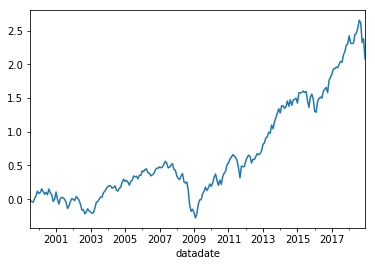

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31    0.120507
2000-12-31   -0.107424
2001-12-31    0.010596
2002-12-31   -0.182351
2003-12-31    0.398617
2004-12-31    0.121506
2005-12-31    0.044825
2006-12-31    0.077105
2007-12-31   -0.018537
2008-12-31   -0.404979
2009-12-31    0.437377
2010-12-31    0.236138
2011-12-31   -0.019171
2012-12-31    0.154110
2013-12-31    0.365377
2014-12-31    0.066751
2015-12-31   -0.006047
2016-12-31    0.131667
2017-12-31    0.177124
2018-12-31   -0.068047
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.949
Model:                            OLS   Adj. R-squared:                  0.948
Method:                 Least Squares   F-statistic:                     1066.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.03e-146
Time:                        13:45:10   Log-Likelihood:                 736.60
No. Observations:                 234   AIC:                            -1463.
Df Residuals:                     229   BIC:                            -1446.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0015      0.001      2.075      0.039    7.52e-05       0.003
mktrf          0.9631      0.020     49.163      0.000       0.925       1.002
me             0.1684      0.023      7.389      0.000       0.123       0.213
ia             0.0688      0.035      1.988      0.048       0.001       0.137
roe           -0.0670      0.030     -2.259      0.025      -0.125      -0.009
==============================================================================
Omnibus:                       91.637   Durbin-Watson:                   1.960
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1455.087
Skew:                           1.056   Prob(JB):                         0.00
Kurtosis:                      15.032   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.949
Model:                            OLS   Adj. R-squared:                  0.948
Method:                 Least Squares   F-statistic:                     1195.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          4.37e-152
Time:                        13:45:10   Log-Likelihood:                 736.60
No. Observations:                 234   AIC:                            -1463.
Df Residuals:                     229   BIC:                            -1446.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0015      0.001      1.739      0.082      -0.000       0.003
mktrf          0.9631      0.031     31.532      0.000       0.903       1.023
me             0.1684      0.089      1.892      0.059      -0.006       0.343
ia             0.0688      0.081      0.848      0.397      -0.090       0.228
roe           -0.0670      0.061     -1.091      0.275      -0.187       0.053
==============================================================================
Omnibus:                       91.637   Durbin-Watson:                   1.960
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1455.087
Skew:                           1.056   Prob(JB):                         0.00
Kurtosis:                      15.032   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.949
Model:                            OLS   Adj. R-squared:                  0.948
Method:                 Least Squares   F-statistic:                     1459.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.26e-161
Time:                        13:45:10   Log-Likelihood:                 736.60
No. Observations:                 234   AIC:                            -1463.
Df Residuals:                     229   BIC:                            -1446.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0015      0.001      1.712      0.087      -0.000       0.003
mktrf          0.9631      0.027     35.728      0.000       0.910       1.016
me             0.1684      0.095      1.765      0.078      -0.019       0.355
ia             0.0688      0.067      1.022      0.307      -0.063       0.201
roe           -0.0670      0.057     -1.182      0.237      -0.178       0.044
==============================================================================
Omnibus:                       91.637   Durbin-Watson:                   1.960
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1455.087
Skew:                           1.056   Prob(JB):                         0.00
Kurtosis:                      15.032   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.950
Model:                            OLS   Adj. R-squared:                  0.949
Method:                 Least Squares   F-statistic:                     869.7
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          2.76e-146
Time:                        13:45:10   Log-Likelihood:                 739.23
No. Observations:                 234   AIC:                            -1466.
Df Residuals:                     228   BIC:                            -1446.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009      0.001      1.215      0.225      -0.001       0.002
mktrf          0.9807      0.019     50.418      0.000       0.942       1.019
smb            0.2556      0.026      9.960      0.000       0.205       0.306
hml            0.1180      0.030      3.898      0.000       0.058       0.178
rmw            0.0550      0.034      1.607      0.109      -0.012       0.122
cma           -0.1249      0.043     -2.871      0.004      -0.211      -0.039
==============================================================================
Omnibus:                       98.710   Durbin-Watson:                   1.841
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1005.787
Skew:                           1.343   Prob(JB):                    3.95e-219
Kurtosis:                      12.795   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.950
Model:                            OLS   Adj. R-squared:                  0.949
Method:                 Least Squares   F-statistic:                     677.6
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.25e-134
Time:                        13:45:10   Log-Likelihood:                 739.23
No. Observations:                 234   AIC:                            -1466.
Df Residuals:                     228   BIC:                            -1446.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009      0.001      1.086      0.278      -0.001       0.002
mktrf          0.9807      0.027     36.119      0.000       0.928       1.034
smb            0.2556      0.064      3.992      0.000       0.130       0.381
hml            0.1180      0.050      2.357      0.018       0.020       0.216
rmw            0.0550      0.044      1.249      0.212      -0.031       0.141
cma           -0.1249      0.067     -1.866      0.062      -0.256       0.006
==============================================================================
Omnibus:                       98.710   Durbin-Watson:                   1.841
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1005.787
Skew:                           1.343   Prob(JB):                    3.95e-219
Kurtosis:                      12.795   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.950
Model:                            OLS   Adj. R-squared:                  0.949
Method:                 Least Squares   F-statistic:                     984.9
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          3.76e-152
Time:                        13:45:10   Log-Likelihood:                 739.23
No. Observations:                 234   AIC:                            -1466.
Df Residuals:                     228   BIC:                            -1446.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009      0.001      1.067      0.286      -0.001       0.002
mktrf          0.9807      0.028     35.538      0.000       0.927       1.035
smb            0.2556      0.066      3.856      0.000       0.126       0.386
hml            0.1180      0.047      2.529      0.011       0.027       0.209
rmw            0.0550      0.039      1.399      0.162      -0.022       0.132
cma           -0.1249      0.059     -2.118      0.034      -0.240      -0.009
==============================================================================
Omnibus:                       98.710   Durbin-Watson:                   1.841
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1005.787
Skew:                           1.343   Prob(JB):                    3.95e-219
Kurtosis:                      12.795   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.956
Model:                            OLS   Adj. R-squared:                  0.955
Method:                 Least Squares   F-statistic:                     1230.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.76e-153
Time:                        13:45:10   Log-Likelihood:                 752.53
No. Observations:                 234   AIC:                            -1495.
Df Residuals:                     229   BIC:                            -1478.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0016      0.001      2.447      0.015       0.000       0.003
mktrf          0.9324      0.017     55.333      0.000       0.899       0.966
smb            0.2404      0.021     11.430      0.000       0.199       0.282
hml            0.1027      0.021      4.916      0.000       0.062       0.144
umd           -0.1008      0.014     -7.354      0.000      -0.128      -0.074
==============================================================================
Omnibus:                       30.266   Durbin-Watson:                   1.847
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              164.363
Skew:                           0.210   Prob(JB):                     2.04e-36
Kurtosis:                       7.084   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.956
Model:                            OLS   Adj. R-squared:                  0.955
Method:                 Least Squares   F-statistic:                     1107.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.73e-148
Time:                        13:45:10   Log-Likelihood:                 752.53
No. Observations:                 234   AIC:                            -1495.
Df Residuals:                     229   BIC:                            -1478.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0016      0.001      2.036      0.042    5.97e-05       0.003
mktrf          0.9324      0.024     38.898      0.000       0.885       0.979
smb            0.2404      0.066      3.625      0.000       0.110       0.370
hml            0.1027      0.032      3.227      0.001       0.040       0.165
umd           -0.1008      0.033     -3.102      0.002      -0.165      -0.037
==============================================================================
Omnibus:                       30.266   Durbin-Watson:                   1.847
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              164.363
Skew:                           0.210   Prob(JB):                     2.04e-36
Kurtosis:                       7.084   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.956
Model:                            OLS   Adj. R-squared:                  0.955
Method:                 Least Squares   F-statistic:                     1442.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          4.68e-161
Time:                        13:45:10   Log-Likelihood:                 752.53
No. Observations:                 234   AIC:                            -1495.
Df Residuals:                     229   BIC:                            -1478.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0016      0.001      1.883      0.060   -6.57e-05       0.003
mktrf          0.9324      0.024     39.126      0.000       0.886       0.979
smb            0.2404      0.065      3.676      0.000       0.112       0.369
hml            0.1027      0.031      3.273      0.001       0.041       0.164
umd           -0.1008      0.032     -3.184      0.001      -0.163      -0.039
==============================================================================
Omnibus:                       30.266   Durbin-Watson:                   1.847
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              164.363
Skew:                           0.210   Prob(JB):                     2.04e-36
Kurtosis:                       7.084   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.933
Model:                            OLS   Adj. R-squared:                  0.931
Method:                 Least Squares   F-statistic:                     402.7
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.26e-66
Time:                        13:45:10   Log-Likelihood:                 348.46
No. Observations:                 120   AIC:                            -686.9
Df Residuals:                     115   BIC:                            -673.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0024      0.001      1.843      0.068      -0.000       0.005
mktrf          0.9690      0.035     27.750      0.000       0.900       1.038
me             0.1099      0.034      3.188      0.002       0.042       0.178
ia             0.0782      0.054      1.448      0.150      -0.029       0.185
roe           -0.0726      0.048     -1.520      0.131      -0.167       0.022
==============================================================================
Omnibus:                       48.033   Durbin-Watson:                   1.990
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              256.748
Skew:                           1.210   Prob(JB):                     1.77e-56
Kurtosis:                       9.745   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.933
Model:                            OLS   Adj. R-squared:                  0.931
Method:                 Least Squares   F-statistic:                     585.5
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.94e-75
Time:                        13:45:10   Log-Likelihood:                 348.46
No. Observations:                 120   AIC:                            -686.9
Df Residuals:                     115   BIC:                            -673.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0024      0.002      1.442      0.149      -0.001       0.006
mktrf          0.9690      0.037     26.088      0.000       0.896       1.042
me             0.1099      0.097      1.131      0.258      -0.081       0.300
ia             0.0782      0.103      0.759      0.448      -0.124       0.280
roe           -0.0726      0.079     -0.920      0.357      -0.227       0.082
==============================================================================
Omnibus:                       48.033   Durbin-Watson:                   1.990
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              256.748
Skew:                           1.210   Prob(JB):                     1.77e-56
Kurtosis:                       9.745   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.933
Model:                            OLS   Adj. R-squared:                  0.931
Method:                 Least Squares   F-statistic:                     774.9
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.81e-82
Time:                        13:45:10   Log-Likelihood:                 348.46
No. Observations:                 120   AIC:                            -686.9
Df Residuals:                     115   BIC:                            -673.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0024      0.002      1.320      0.187      -0.001       0.006
mktrf          0.9690      0.030     32.697      0.000       0.911       1.027
me             0.1099      0.106      1.034      0.301      -0.098       0.318
ia             0.0782      0.088      0.890      0.374      -0.094       0.251
roe           -0.0726      0.072     -1.012      0.312      -0.213       0.068
==============================================================================
Omnibus:                       48.033   Durbin-Watson:                   1.990
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              256.748
Skew:                           1.210   Prob(JB):                     1.77e-56
Kurtosis:                       9.745   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.934
Model:                            OLS   Adj. R-squared:                  0.931
Method:                 Least Squares   F-statistic:                     320.7
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.15e-65
Time:                        13:45:10   Log-Likelihood:                 348.70
No. Observations:                 120   AIC:                            -685.4
Df Residuals:                     114   BIC:                            -668.7
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0017      0.001      1.293      0.199      -0.001       0.004
mktrf          1.0326      0.037     27.976      0.000       0.959       1.106
smb            0.2368      0.042      5.665      0.000       0.154       0.320
hml            0.0769      0.051      1.500      0.136      -0.025       0.178
rmw            0.1193      0.060      1.976      0.051      -0.000       0.239
cma           -0.1041      0.066     -1.573      0.119      -0.235       0.027
==============================================================================
Omnibus:                       43.365   Durbin-Watson:                   1.908
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              163.987
Skew:                           1.204   Prob(JB):                     2.46e-36
Kurtosis:                       8.196   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.934
Model:                            OLS   Adj. R-squared:                  0.931
Method:                 Least Squares   F-statistic:                     344.0
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.17e-67
Time:                        13:45:10   Log-Likelihood:                 348.70
No. Observations:                 120   AIC:                            -685.4
Df Residuals:                     114   BIC:                            -668.7
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0017      0.001      1.202      0.229      -0.001       0.005
mktrf          1.0326      0.044     23.539      0.000       0.947       1.119
smb            0.2368      0.084      2.834      0.005       0.073       0.401
hml            0.0769      0.072      1.060      0.289      -0.065       0.219
rmw            0.1193      0.066      1.818      0.069      -0.009       0.248
cma           -0.1041      0.095     -1.094      0.274      -0.290       0.082
==============================================================================
Omnibus:                       43.365   Durbin-Watson:                   1.908
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              163.987
Skew:                           1.204   Prob(JB):                     2.46e-36
Kurtosis:                       8.196   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.934
Model:                            OLS   Adj. R-squared:                  0.931
Method:                 Least Squares   F-statistic:                     506.8
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.32e-76
Time:                        13:45:10   Log-Likelihood:                 348.70
No. Observations:                 120   AIC:                            -685.4
Df Residuals:                     114   BIC:                            -668.7
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0017      0.002      1.120      0.263      -0.001       0.005
mktrf          1.0326      0.046     22.624      0.000       0.943       1.122
smb            0.2368      0.087      2.720      0.007       0.066       0.407
hml            0.0769      0.069      1.117      0.264      -0.058       0.212
rmw            0.1193      0.068      1.766      0.077      -0.013       0.252
cma           -0.1041      0.081     -1.284      0.199      -0.263       0.055
==============================================================================
Omnibus:                       43.365   Durbin-Watson:                   1.908
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              163.987
Skew:                           1.204   Prob(JB):                     2.46e-36
Kurtosis:                       8.196   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.943
Model:                            OLS   Adj. R-squared:                  0.941
Method:                 Least Squares   F-statistic:                     475.1
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.71e-70
Time:                        13:45:10   Log-Likelihood:                 357.76
No. Observations:                 120   AIC:                            -705.5
Df Residuals:                     115   BIC:                            -691.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0027      0.001      2.333      0.021       0.000       0.005
mktrf          0.9324      0.028     32.750      0.000       0.876       0.989
smb            0.2120      0.032      6.539      0.000       0.148       0.276
hml            0.1043      0.032      3.212      0.002       0.040       0.169
umd           -0.1147      0.020     -5.731      0.000      -0.154      -0.075
==============================================================================
Omnibus:                        6.708   Durbin-Watson:                   1.863
Prob(Omnibus):                  0.035   Jarque-Bera (JB):               11.750
Skew:                          -0.013   Prob(JB):                      0.00281
Kurtosis:                       4.533   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.943
Model:                            OLS   Adj. R-squared:                  0.941
Method:                 Least Squares   F-statistic:                     530.8
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.14e-73
Time:                        13:45:10   Log-Likelihood:                 357.76
No. Observations:                 120   AIC:                            -705.5
Df Residuals:                     115   BIC:                            -691.6
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0027      0.001      2.052      0.040       0.000       0.005
mktrf          0.9324      0.037     25.405      0.000       0.860       1.004
smb            0.2120      0.074      2.860      0.004       0.067       0.357
hml            0.1043      0.040      2.636      0.008       0.027       0.182
umd           -0.1147      0.036     -3.188      0.001      -0.185      -0.044
==============================================================================
Omnibus:                        6.708   Durbin-Watson:                   1.863
Prob(Omnibus):                  0.035   Jarque-Bera (JB):               11.750
Skew:                          -0.013   Prob(JB):                      0.00281
Kurtosis:                       4.533   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.943
Model:                            OLS   Adj. R-squared:                  0.941
Method:                 Least Squares   F-statistic:                     682.6
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.24e-79
Time:                        13:45:10   Log-Likelihood:                 357.76
No. Observations:                 120   AIC:                            -705.5
Df Residuals:                     115   BIC:                            -691.6
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0027      0.001      1.885      0.059      -0.000       0.006
mktrf          0.9324      0.038     24.617      0.000       0.858       1.007
smb            0.2120      0.073      2.890      0.004       0.068       0.356
hml            0.1043      0.040      2.577      0.010       0.025       0.184
umd           -0.1147      0.034     -3.406      0.001      -0.181      -0.049
==============================================================================
Omnibus:                        6.708   Durbin-Watson:                   1.863
Prob(Omnibus):                  0.035   Jarque-Bera (JB):               11.750
Skew:                          -0.013   Prob(JB):                      0.00281
Kurtosis:                       4.533   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.990
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                     2597.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          4.32e-107
Time:                        13:45:10   Log-Likelihood:                 468.27
No. Observations:                 114   AIC:                            -926.5
Df Residuals:                     109   BIC:                            -912.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0013      0.000      3.324      0.001       0.001       0.002
mktrf          0.9195      0.012     76.851      0.000       0.896       0.943
me             0.3440      0.018     18.622      0.000       0.307       0.381
ia             0.0087      0.026      0.339      0.735      -0.042       0.059
roe           -0.0802      0.023     -3.561      0.001      -0.125      -0.036
==============================================================================
Omnibus:                        1.035   Durbin-Watson:                   1.768
Prob(Omnibus):                  0.596   Jarque-Bera (JB):                0.645
Skew:                           0.159   Prob(JB):                        0.724
Kurtosis:                       3.188   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.990
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                     1607.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           6.88e-96
Time:                        13:45:10   Log-Likelihood:                 468.27
No. Observations:                 114   AIC:                            -926.5
Df Residuals:                     109   BIC:                            -912.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0013      0.000      3.223      0.001       0.001       0.002
mktrf          0.9195      0.018     51.958      0.000       0.885       0.954
me             0.3440      0.025     13.838      0.000       0.295       0.393
ia             0.0087      0.027      0.328      0.743      -0.043       0.061
roe           -0.0802      0.020     -3.976      0.000      -0.120      -0.041
==============================================================================
Omnibus:                        1.035   Durbin-Watson:                   1.768
Prob(Omnibus):                  0.596   Jarque-Bera (JB):                0.645
Skew:                           0.159   Prob(JB):                        0.724
Kurtosis:                       3.188   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.990
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                     1861.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.60e-99
Time:                        13:45:10   Log-Likelihood:                 468.27
No. Observations:                 114   AIC:                            -926.5
Df Residuals:                     109   BIC:                            -912.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0013      0.000      3.468      0.001       0.001       0.002
mktrf          0.9195      0.017     53.126      0.000       0.886       0.953
me             0.3440      0.024     14.256      0.000       0.297       0.391
ia             0.0087      0.023      0.376      0.707      -0.037       0.054
roe           -0.0802      0.018     -4.440      0.000      -0.116      -0.045
==============================================================================
Omnibus:                        1.035   Durbin-Watson:                   1.768
Prob(Omnibus):                  0.596   Jarque-Bera (JB):                0.645
Skew:                           0.159   Prob(JB):                        0.724
Kurtosis:                       3.188   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.990
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                     2119.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          5.00e-106
Time:                        13:45:10   Log-Likelihood:                 469.90
No. Observations:                 114   AIC:                            -927.8
Df Residuals:                     108   BIC:                            -911.4
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0006      0.000      1.473      0.144      -0.000       0.001
mktrf          0.9228      0.011     81.653      0.000       0.900       0.945
smb            0.3255      0.018     17.742      0.000       0.289       0.362
hml            0.0642      0.023      2.743      0.007       0.018       0.111
rmw           -0.0968      0.029     -3.377      0.001      -0.154      -0.040
cma           -0.0505      0.036     -1.389      0.168      -0.123       0.022
==============================================================================
Omnibus:                        6.699   Durbin-Watson:                   2.011
Prob(Omnibus):                  0.035   Jarque-Bera (JB):               11.316
Skew:                           0.099   Prob(JB):                      0.00349
Kurtosis:                       4.531   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.990
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                     964.8
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           7.21e-88
Time:                        13:45:10   Log-Likelihood:                 469.90
No. Observations:                 114   AIC:                            -927.8
Df Residuals:                     108   BIC:                            -911.4
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0006      0.001      1.160      0.246      -0.000       0.002
mktrf          0.9228      0.020     47.049      0.000       0.884       0.961
smb            0.3255      0.023     14.425      0.000       0.281       0.370
hml            0.0642      0.014      4.588      0.000       0.037       0.092
rmw           -0.0968      0.025     -3.911      0.000      -0.145      -0.048
cma           -0.0505      0.029     -1.754      0.079      -0.107       0.006
==============================================================================
Omnibus:                        6.699   Durbin-Watson:                   2.011
Prob(Omnibus):                  0.035   Jarque-Bera (JB):               11.316
Skew:                           0.099   Prob(JB):                      0.00349
Kurtosis:                       4.531   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.990
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                     1465.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.74e-97
Time:                        13:45:10   Log-Likelihood:                 469.90
No. Observations:                 114   AIC:                            -927.8
Df Residuals:                     108   BIC:                            -911.4
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0006      0.001      1.098      0.272      -0.000       0.002
mktrf          0.9228      0.019     49.457      0.000       0.886       0.959
smb            0.3255      0.023     13.925      0.000       0.280       0.371
hml            0.0642      0.011      5.846      0.000       0.043       0.086
rmw           -0.0968      0.019     -5.097      0.000      -0.134      -0.060
cma           -0.0505      0.025     -2.060      0.039      -0.099      -0.002
==============================================================================
Omnibus:                        6.699   Durbin-Watson:                   2.011
Prob(Omnibus):                  0.035   Jarque-Bera (JB):               11.316
Skew:                           0.099   Prob(JB):                      0.00349
Kurtosis:                       4.531   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.988
Method:                 Least Squares   F-statistic:                     2360.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          7.46e-105
Time:                        13:45:10   Log-Likelihood:                 462.88
No. Observations:                 114   AIC:                            -915.8
Df Residuals:                     109   BIC:                            -902.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004      0.000      0.930      0.355      -0.000       0.001
mktrf          0.9297      0.012     78.203      0.000       0.906       0.953
smb            0.3495      0.019     18.857      0.000       0.313       0.386
hml            0.0757      0.019      3.968      0.000       0.038       0.114
umd           -0.0236      0.014     -1.637      0.105      -0.052       0.005
==============================================================================
Omnibus:                        6.537   Durbin-Watson:                   1.945
Prob(Omnibus):                  0.038   Jarque-Bera (JB):                9.865
Skew:                           0.185   Prob(JB):                      0.00721
Kurtosis:                       4.393   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.988
Method:                 Least Squares   F-statistic:                     756.8
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.64e-78
Time:                        13:45:10   Log-Likelihood:                 462.88
No. Observations:                 114   AIC:                            -915.8
Df Residuals:                     109   BIC:                            -902.1
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004      0.001      0.728      0.467      -0.001       0.001
mktrf          0.9297      0.021     44.036      0.000       0.888       0.971
smb            0.3495      0.021     16.868      0.000       0.309       0.390
hml            0.0757      0.016      4.698      0.000       0.044       0.107
umd           -0.0236      0.013     -1.778      0.075      -0.050       0.002
==============================================================================
Omnibus:                        6.537   Durbin-Watson:                   1.945
Prob(Omnibus):                  0.038   Jarque-Bera (JB):                9.865
Skew:                           0.185   Prob(JB):                      0.00721
Kurtosis:                       4.393   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.988
Method:                 Least Squares   F-statistic:                     1028.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.53e-85
Time:                        13:45:10   Log-Likelihood:                 462.88
No. Observations:                 114   AIC:                            -915.8
Df Residuals:                     109   BIC:                            -902.1
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004      0.001      0.713      0.476      -0.001       0.001
mktrf          0.9297      0.020     46.136      0.000       0.890       0.969
smb            0.3495      0.020     17.059      0.000       0.309       0.390
hml            0.0757      0.013      5.632      0.000       0.049       0.102
umd           -0.0236      0.012     -2.027      0.043      -0.046      -0.001
==============================================================================
Omnibus:                        6.537   Durbin-Watson:                   1.945
Prob(Omnibus):                  0.038   Jarque-Bera (JB):                9.865
Skew:                           0.185   Prob(JB):                      0.00721
Kurtosis:                       4.393   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""